# Implementação Pix2Pix

A tradução de imagens para imagens é uma tarefa fundamental na visão computacional, focando em transformar uma representação de uma cena em outra, com base em dados de treinamento adequados. Um dos desafios principais é definir uma função de perda eficaz que permita à rede neural aprender a prever pixels a partir de pixels.

No âmbito das redes neurais convolucionais (CNNs), pode-se pensar em utilizar a distância euclidiana como função de perda. No entanto, isso geralmente resulta em saídas borradas, pois a distância euclidiana minimiza a perda ao aproximar-se da média de todas as saídas possíveis para um pixel específico. Consequentemente, as imagens geradas tem pouca nitidez.

Para mitigar esse problema, é necessário desenvolver funções de perda que encorajem a geração de saídas realistas e nítidas. Idealmente, gostaríamos que a função de perda pudesse ser definida em um nível mais alto, como "Faça com que a saída seja indistinguível da realidade." Essa ideia é explorada pelas Redes Adversariais Generativas (GANs), que utilizam uma rede discriminadora para aprender a diferenciar imagens reais de geradas, enquanto a rede geradora tenta produzir imagens que enganem a discriminadora.

O Pix2Pix faz uso das GANs condicionais (cGANs), onde as saídas são condicionadas a entradas específicas, permitindo uma tradução de imagem para imagem mais precisa e alinhada com o contexto da entrada. Isso demonstra como as cGANs podem ser aplicadas como uma solução de propósito geral para tradução de imagens, abrangendo aplicações desde a transformação de esboços em fotografias até a coloração de imagens em preto e branco.

Para esse trabalho será utilizado o dataset [Facades](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz) disponibilizado pelos próprios autores do paper que introduziu o Pix2Pix.

## Imports

In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## Carregamento do Conjunto de Dados

In [3]:
get_ipython().system('wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz')

--2024-08-06 23:04:40--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  3.99MB/s    in 8.6s    

2024-08-06 23:04:49 (3.34 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [4]:
get_ipython().system("tar -zxf 'facades.tar.gz'")

In [5]:
dataset_path = "./facades/"

In [6]:
sample_image = tf.io.read_file(str(dataset_path + 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


Nesse dataset, cada imagem tem tamanho 256 x 512, de forma que contém duas imagens de 256 x 256 concatenadas.

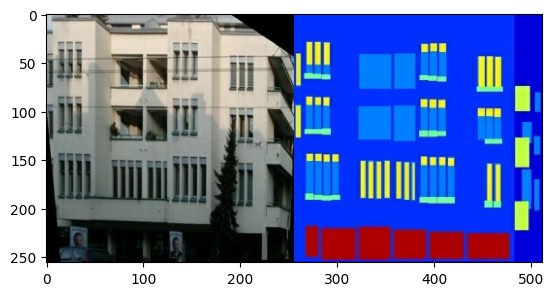

In [7]:
plt.figure()
plt.imshow(sample_image)

A seguir, define-se uma função para carregar uma imagem e separá-la em duas partes: a imagem real da fachada do edifício e sua respectiva segmentação.

In [8]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

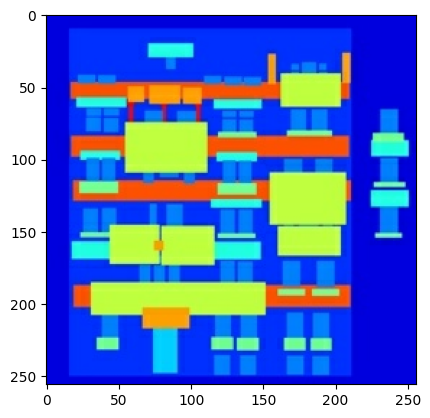

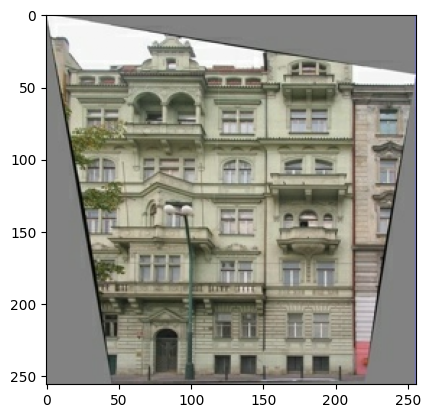

In [9]:
inp, re = load(str(dataset_path + 'train/100.jpg'))
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

## Pré-processamento dos Dados

Nos apêndices do artigo Pix2Pix, é detalhada a aplicação de um random jitter que redimensiona a imagem para 286 x 286 pixels e, em seguida, a corta aleatoriamente para 256 x 256 pixels. Além disso, é aplicado um espelhamento horizontal aleatório, seguido de uma normalização para o intervalo [-1, 1]. Esses processos são aplicados exclusivamente no conjunto de treinamento.

In [10]:
BUFFER_SIZE = 400

BATCH_SIZE = 1 # Best result in the Pix2Pix paper

IMG_WIDTH, IMG_HEIGHT= 256, 256

In [11]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [12]:
# Normalizes the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [13]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [14]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

A seguir, é definido um pipeline de entrada de dados utilizando as funções criadas anteriormente.

In [15]:
train_dataset = tf.data.Dataset.list_files(str(dataset_path + 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [16]:
try:
    test_dataset = tf.data.Dataset.list_files(str(dataset_path + 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(dataset_path + 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Construção do Gerador

O gerador é um modelo composto por um **encoder** e um **decoder**, também conhecidos como **downsampler** e **upsampler**, formando essencialmente uma U-Net modificada. O processo de geração de uma imagem de saída a partir de uma imagem de entrada envolve duas etapas principais:

1. **Downsampling**: O gerador reduz a imagem de entrada até uma camada de gargalo (*bottleneck layer*), onde aprende uma representação no espaço latente da imagem.

2. **Upsampling**: A partir dessa representação latente, o gerador realiza o upsampling até atingir o tamanho desejado da imagem de saída.

O nome U-Net vem do formato da rede, em que **skip connections** são adicionadas entre as camadas de downsampling e upsampling. Essas conexões diretas entre camadas correspondentes ajudam a preservar características importantes da imagem de entrada, permitindo que o gerador combine informações de diferentes resoluções.

No processo de **downsampling**, a rede aprende a identificar o que existe na imagem, enquanto no **upsampling**, ela aprende onde esses elementos aparecem. Isso torna a U-Net particularmente eficaz em tarefas de segmentação e tradução de imagens.

### Estrutura dos blocos do Gerador:

 - **Encoder (Downsampler)**:
   - Convolução
   - Normalização em Batch
   - Leaky ReLU

 - **Decoder (Upsampler)**:
   - Convolução Transposta
   - Normalização em Batch
   - Dropout
   - ReLU

In [17]:
OUTPUT_CHANNELS = 3

In [18]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [19]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Definindo a Função de Perda do Gerador

O gerador de uma Rede Adversarial Generativa Condicional (cGAN) é treinado para enganar o discriminador, fazendo com que ele classifique as imagens geradas como reais. Além disso, o gerador deve criar imagens semelhantes às do conjunto de dados original, minimizando a diferença entre as imagens de entrada e as geradas usando uma perda L1, ou Erro Médio Absoluto (MAE). Isso ajuda o gerador a aprender a produzir saídas que sejam visualmente realistas e consistentes com as imagens de destino.

Para equilibrar esses objetivos, a atualização do gerador é feita pela soma ponderada das perdas adversarial e L1. Os autores do Pix2Pix sugerem atribuir um peso de 100 para a perda L1 e um peso de 1 para a perda adversarial, incentivando o gerador a criar transformações plausíveis das imagens de entrada.

Para implementar isso, é criado um modelo composto que integra o gerador e o discriminador. Neste modelo, a imagem original é alimentada no gerador, e a saída gerada é passada como entrada "alvo" para o discriminador. O discriminador, então, avalia se a imagem gerada parece uma tradução autêntica da imagem de origem.

Durante o treinamento, o discriminador é atualizado separadamente, e seus pesos são mantidos fixos quando o modelo composto é atualizado. O modelo composto aprende a classificar as imagens geradas como reais (usando perda de entropia cruzada) e também compara a tradução gerada com a imagem real (usando perda L1).

Essa abordagem permite que o gerador melhore constantemente, produzindo imagens que são tanto realistas quanto fiéis às entradas originais.

In [20]:
LAMBDA = 100

In [21]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Construção do Discriminador

O discriminador no Pix2Pix prediz a probabilidade de uma imagem ser real em relação a uma imagem de destino, utilizando a abordagem chamada PatchGAN. Esta técnica classifica se cada patch (bloco) da imagem é real ou não.

No artigo do Pix2Pix, define-se que cada predição lida com patches de tamanho 70x70 pixels. A principal vantagem dessa abordagem é que ela pode ser aplicada a imagens de diferentes tamanhos, mantendo a capacidade de detectar características locais em diversas escalas.

### Estrutura dos Blocos do Discriminador:

 - Convolução
 - Normalização em Batch
 - Leaky ReLU

O discriminador recebe duas entradas: a imagem de entrada e a imagem de destino. Ele concatena essas imagens e as processa juntas para determinar se a imagem de entrada é uma tradução realista da imagem de destino.

In [23]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

### Definindo a Função de Perda do Discriminador

A função de perda do discriminador é relativamente simples, baseada na entropia cruzada entre as saídas previstas e os valores esperados. O discriminador é treinado para identificar corretamente as imagens reais como reais e as imagens geradas como falsas. Portanto, a perda do discriminador é calculada como a soma da entropia cruzada desses dois cenários: classificações corretas das imagens reais e classificações corretas das imagens falsas.

In [24]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Definindo o Otimizador

Para o treinamento do modelo, utiliza-se o otimizador Adam com uma taxa de aprendizado (learning rate) de 0.0002 e um parâmetro beta de 0.5, conforme especificado no artigo.

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
generator = Generator()
discriminator = Discriminator()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Treinamento do Modelo

A seguir, definimos as funções necessárias para o treinamento do modelo, incluindo uma função para geração de imagens que plota as imagens preditas à medida que o treinamento avança. O modelo será treinado por 100 épocas devido a limitações de tempo, embora o artigo original recomende 200 épocas. O tamanho do lote (batch size) é configurado para 1.

In [27]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [28]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [29]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [32]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 110.98 sec



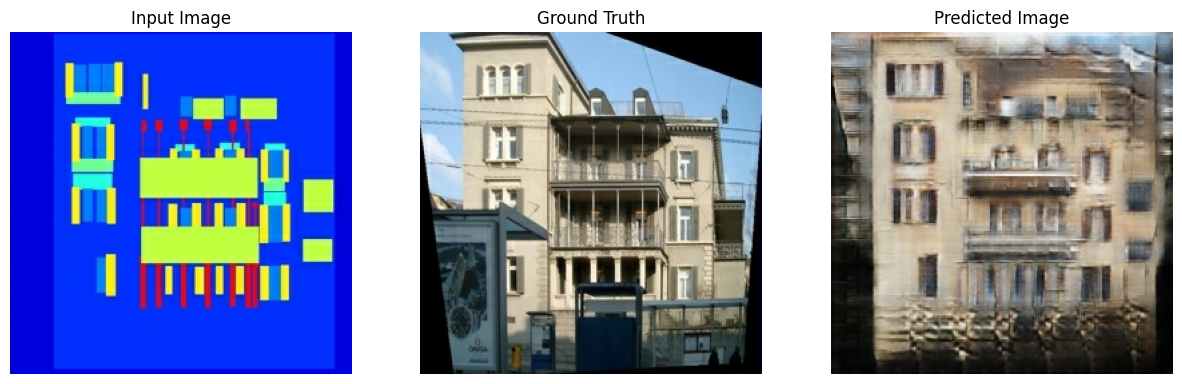

Step: 39k
....................................................................................................

In [33]:
fit(train_dataset, test_dataset, steps=40000)

## Avaliação do modelo

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

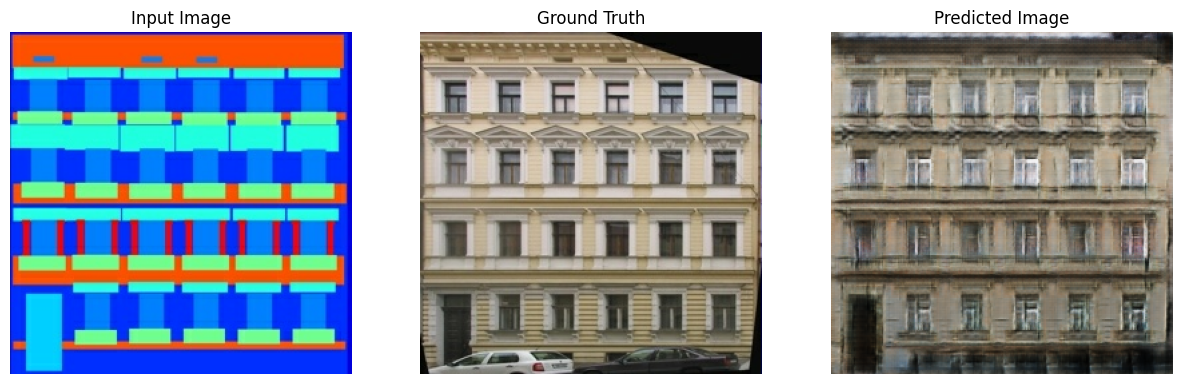

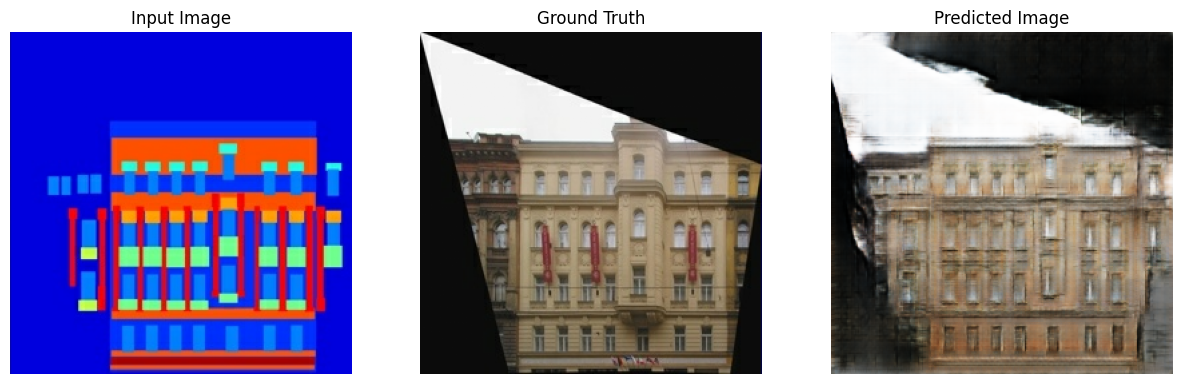

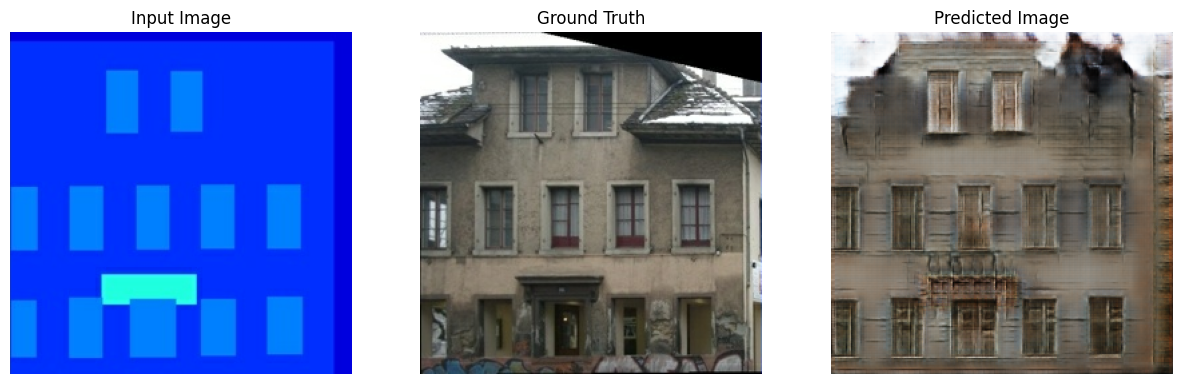

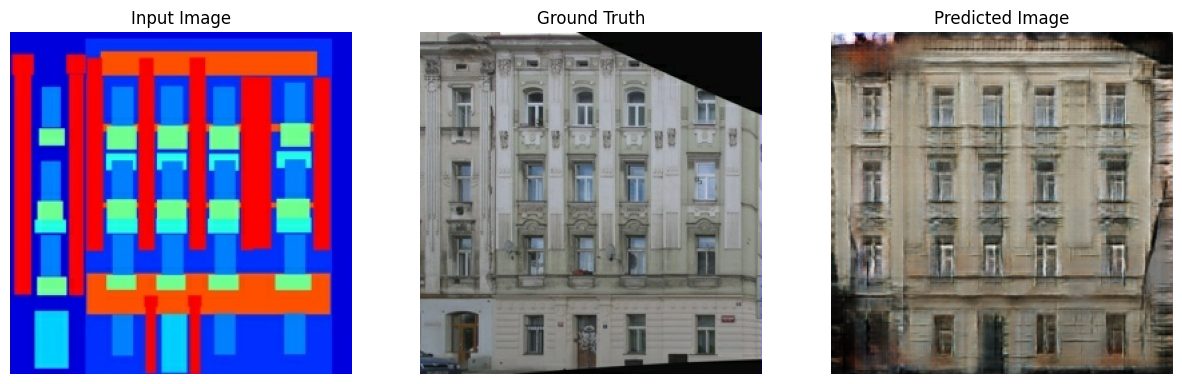

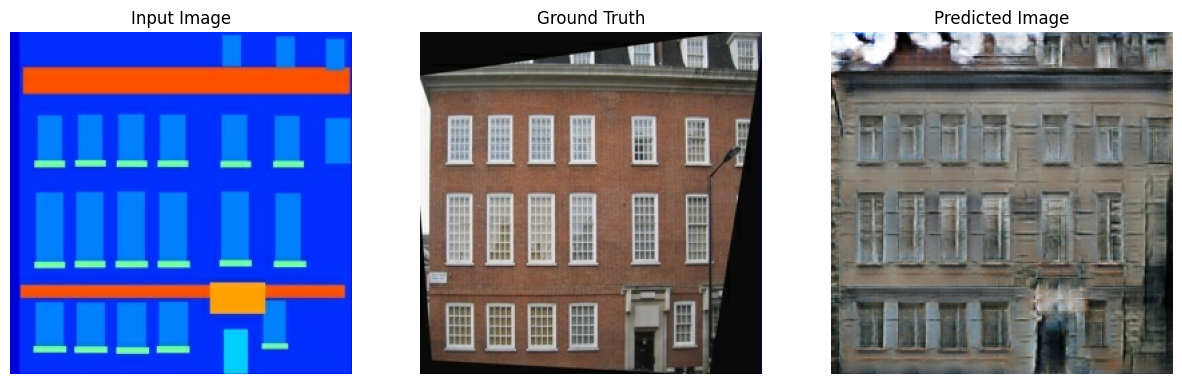

In [35]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

As imagens geradas pelo modelo estão razoáveis e capturam as características principais esperadas. No entanto, percebe-se que o modelo poderia se beneficiar de mais épocas de treinamento para melhorar a qualidade e o detalhamento das imagens. Com mais epocas, espera-se obter resultados melhores e mais realistas.